## 分析ケース②: MLアルゴリズムへの差分プライバシー適用

In [17]:
!pip install diffprivlib

/tmp/ipykernel_362227/3754234034.py:46: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]


Non-DP accuracy:  0.6633663366336634


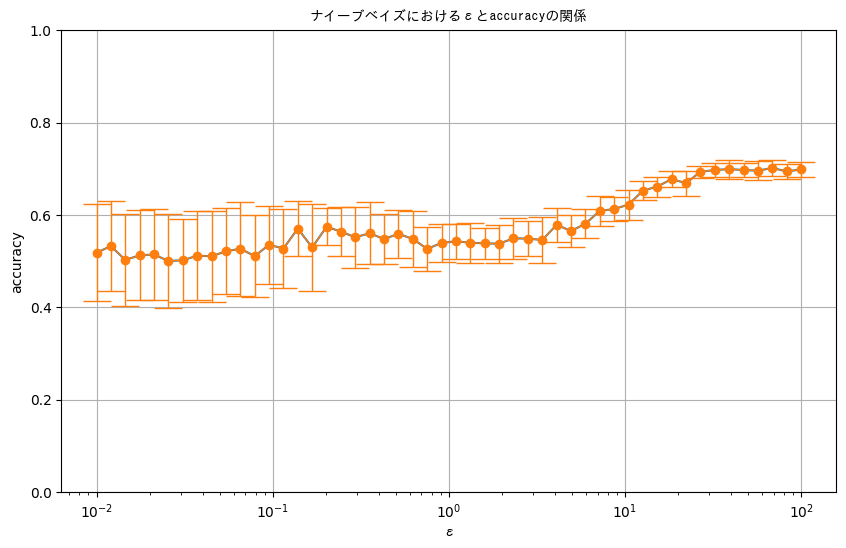

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB as SklearnGaussianNB
import numpy as np
import spacy
from typing import List, Tuple
import itertools
import matplotlib.pyplot as plt
from diffprivlib.models import GaussianNB as DPGaussianNB
import matplotlib.font_manager as fm

# データの読み込み
data_path = './data/reviews_with_sentiment.csv'
df = pd.read_csv(data_path)
font_path = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'  # フォントパスを指定
font_prop = fm.FontProperties(fname=font_path)
# spaCyの日本語モデルのロード
nlp = spacy.load('ja_ginza')

# 抽出する品詞の指定
POS = ['ADJ', 'ADV', 'INTJ', 'PROPN', 'NOUN', 'VERB']
MAX_TERMS_IN_DOC = 5
NGRAM = 1
MAX_DF = 1.0
MIN_DF = 0.01
NUM_VOCAB = 10000

def flatten(*lists) -> list:
    res = []
    for l in list(itertools.chain.from_iterable(lists)):
        for e in l:
            res.append(e)
    return res

def remove_duplicates(l: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
    d = {}
    for e in l:
        d[e[0]] = e[1]
    return list(d.items())

# 形態素解析とBoWの生成
tokens = []
for doc in df["review"]:
    parsed_doc = nlp(doc)
    similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]
    similarities = remove_duplicates(similarities)
    similarities = sorted(similarities, key=lambda sim: sim[1], reverse=True)[:MAX_TERMS_IN_DOC]
    tokens.append([similarity[1] for similarity in similarities])

cv = CountVectorizer(ngram_range=(1, NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
bow = cv.fit_transform([" ".join(ts) for ts in tokens]).toarray()

# ラベルの付与とデータセットの分割
m = {
    "positive": 1,
    "neutral": 0,
    "negative": 0,
}
df["sentiment"] = df["sentiment"].map(m)
df["bow"] = bow.tolist()

X_train, X_test, y_train, y_test = train_test_split(df["bow"], df["sentiment"], test_size=0.2)
X_train = [list(x) for x in X_train]
X_test = [list(x) for x in X_test]

# 差分プライバシーなしのナイーブベイズ
clf = SklearnGaussianNB()
clf.fit(X_train, y_train)
print("Non-DP accuracy: ", clf.score(X_test, y_test))

# 差分プライバシーありのナイーブベイズ
epsilons = np.logspace(-2, 2, 50)
dim = np.array(X_train).shape[1]
lowers = np.zeros(dim)
uppers = np.ones(dim)
accuracies = {}

for epsilon in epsilons:
    accuracy = []
    for _ in range(20):
        dp_clf = DPGaussianNB(bounds=(lowers, uppers), epsilon=epsilon)
        dp_clf.fit(X_train, y_train)
        accuracy.append(dp_clf.score(X_test, y_test))
    accuracies[epsilon] = accuracy

# 結果をグラフに描画
x = epsilons
y = [np.mean(accuracies[eps]) for eps in epsilons]
e = [np.std(accuracies[eps]) for eps in epsilons]

plt.figure(figsize=(10, 6))
plt.semilogx(x, y)
plt.errorbar(x, y, yerr=e, marker='o', capthick=1, capsize=10, lw=1)
plt.xlabel('ε', fontproperties=font_prop)
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('ナイーブベイズにおけるεとaccuracyの関係', fontproperties=font_prop)
plt.grid(True)
plt.show()

## ロジスティック回帰

In [2]:

from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB as SklearnGaussianNB
import numpy as np
import spacy
from typing import List, Tuple
import itertools
import matplotlib.pyplot as plt
from diffprivlib.models import GaussianNB as DPGaussianNB
import matplotlib.font_manager as fm

# データの読み込み
data_path = './data/reviews_with_sentiment.csv'
df = pd.read_csv(data_path)
font_path = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'  # フォントパスを指定
font_prop = fm.FontProperties(fname=font_path)
# spaCyの日本語モデルのロード
nlp = spacy.load('ja_ginza')

# 抽出する品詞の指定
POS = ['ADJ', 'ADV', 'INTJ', 'PROPN', 'NOUN', 'VERB']
MAX_TERMS_IN_DOC = 5
NGRAM = 1
MAX_DF = 1.0
MIN_DF = 0.01
NUM_VOCAB = 10000

def flatten(*lists) -> list:
    res = []
    for l in list(itertools.chain.from_iterable(lists)):
        for e in l:
            res.append(e)
    return res

def remove_duplicates(l: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
    d = {}
    for e in l:
        d[e[0]] = e[1]
    return list(d.items())

# 形態素解析とBoWの生成
tokens = []
for doc in df["review"]:
    parsed_doc = nlp(doc)
    similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]
    similarities = remove_duplicates(similarities)
    similarities = sorted(similarities, key=lambda sim: sim[1], reverse=True)[:MAX_TERMS_IN_DOC]
    tokens.append([similarity[1] for similarity in similarities])

cv = CountVectorizer(ngram_range=(1, NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
bow = cv.fit_transform([" ".join(ts) for ts in tokens]).toarray()

# ラベルの付与とデータセットの分割
m = {
    "positive": 1,
    "neutral": 0,
    "negative": 0,
}
df["sentiment"] = df["sentiment"].map(m)
df["bow"] = bow.tolist()

X_train, X_test, y_train, y_test = train_test_split(df["bow"], df["sentiment"], test_size=0.2)
X_train = [list(x) for x in X_train]
X_test = [list(x) for x in X_test]
# 差分プライバシーなしのロジスティック回帰
clf = LogisticRegression(random_state=0).fit(X_train, y_train.to_numpy())
print("Non-DP accuracy: ", clf.score(X_test, y_test.to_numpy()))


/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/tmp/ipykernel_772257/1424478305.py:47: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]


Non-DP accuracy:  0.7200720072007201


/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12451 (\N{KATAKANA LETTER SMALL I})

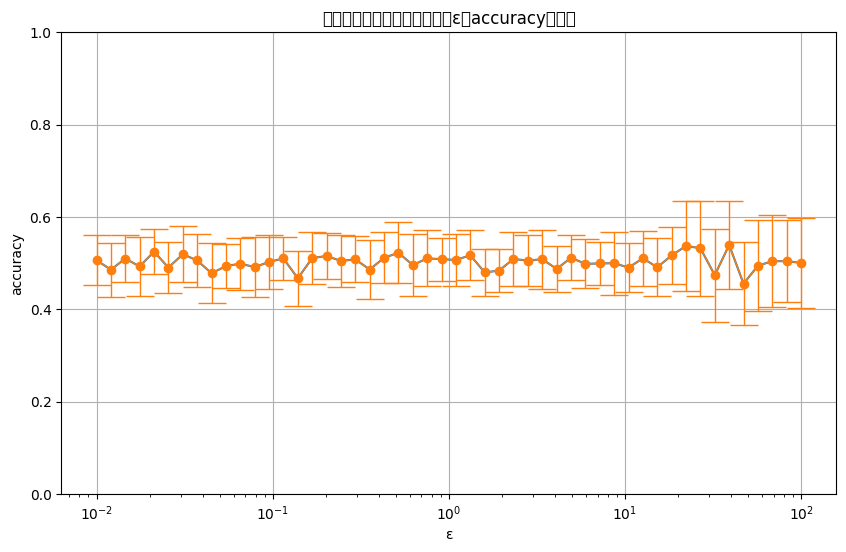

In [3]:

# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=0).fit(X_train, y_train.to_numpy())
# print(&quot;accuracy: &quot;, clf.score(X_test, y_test.to_numpy()))
import math
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.models import LogisticRegression as DPLR

epsilons = np.logspace(-2, 2, 50)
dim = np.array(X_train).shape[1]
data_norm = math.sqrt(dim)
accuracies = {}

for epsilon in epsilons:
    accuracy = []
    for i in range(20):
        clf = DPLR(data_norm=data_norm, epsilon=epsilon).fit(X_train, y_train.to_numpy())
        accuracy.append(clf.score(X_test, y_test.to_numpy()))
    accuracies[epsilon] = accuracy

# 結果をグラフに描画
x = epsilons
y = [np.mean(accuracies[eps]) for eps in epsilons]
e = [np.std(accuracies[eps]) for eps in epsilons]

plt.figure(figsize=(10, 6))
plt.semilogx(x, y)
plt.errorbar(x, y, yerr=e, marker='o', capthick=1, capsize=10, lw=1)
plt.xlabel('ε')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('ロジスティック回帰におけるεとaccuracyの関係', fontproperties=font_prop)
plt.grid(True)
plt.show()

# import math
# import numpy as np
# import matplotlib.pyplot as plt
# from diffprivlib.models import LogisticRegression
# epsilons = np.logspace(-2, 2, 50)
# dim = np.array(X_train).shape[1]
# data_norm = math.sqrt(dim)
# accuracies = {}
# for epsilon in epsilons:
#   accuracy = []
#   for i in range(20):
#     clf = LogisticRegression(data_norm=data_norm, epsilon=epsilon).fit(X_train, y_train.to_numpy())
#     accuracy.append(clf.score(X_test, y_test.to_numpy()))
#   accuracies[epsilon] = accuracy

## TF-IDFを使用した差分プライバシー付きロジスティック回帰

In [ ]:
# データの読み込み
data_path = './data/reviews_with_sentiment.csv'
df = pd.read_csv(data_path)

# 欠損値の確認
print(df.isnull().sum())

# 欠損値の削除
df = df.dropna()

# spaCyの日本語モデルのロード
nlp = spacy.load('ja_ginza')

# 抽出する品詞の指定
POS = ['ADJ', 'ADV', 'INTJ', 'PROPN', 'NOUN', 'VERB']
MAX_TERMS_IN_DOC = 5
NGRAM = 1
MAX_DF = 1.0
MIN_DF = 0.01
NUM_VOCAB = 10000

def flatten(*lists) -> list:
    res = []
    for l in list(itertools.chain.from_iterable(lists)):
        for e in l:
            res.append(e)
    return res

def remove_duplicates(l: List[Tuple[str, float]]) -> List[Tuple[str, float]]:
    d = {}
    for e in l:
        d[e[0]] = e[1]
    return list(d.items())

# 形態素解析とBoWの生成
tokens = []
for doc in df["review"]:
    parsed_doc = nlp(doc)
    similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]
    similarities = remove_duplicates(similarities)
    similarities = sorted(similarities, key=lambda sim: sim[1], reverse=True)[:MAX_TERMS_IN_DOC]
    tokens.append([similarity[1] for similarity in similarities])

cv = CountVectorizer(ngram_range=(1, NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
tfidf_bow = cv.fit_transform([" ".join(ts) for ts in tokens]).toarray()

# ラベルの付与とデータセットの分割
m = {
    "positive": 1,
    "neutral": 0,
    "negative": 0,
}
df["sentiment"] = df["sentiment"].map(m)
df["bow"] = tfidf_bow.tolist()

# 欠損値の再確認
print(df.isnull().sum())

# 欠損値が残っている場合は再度削除
df = df.dropna()

X_train, X_test, y_train, y_test = train_test_split(df["bow"], df["sentiment"], test_size=0.2)
X_train = [list(x) for x in X_train]
X_test = [list(x) for x in X_test]

# 差分プライバシーなしのロジスティック回帰
clf = LogisticRegression(random_state=0).fit(X_train, y_train.to_numpy())
print("Non-DP accuracy: ", clf.score(X_test, y_test.to_numpy()))

review       0
sentiment    0
dtype: int64


/tmp/ipykernel_362227/346474164.py:39: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarities = [(token.similarity(parsed_doc), token.lemma_) for token in parsed_doc if token.pos_ in POS]


review       0
sentiment    0
bow          0
dtype: int64
Non-DP accuracy:  0.7002700270027002


/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12451 (\N{KATAKANA LETTER SMALL I})

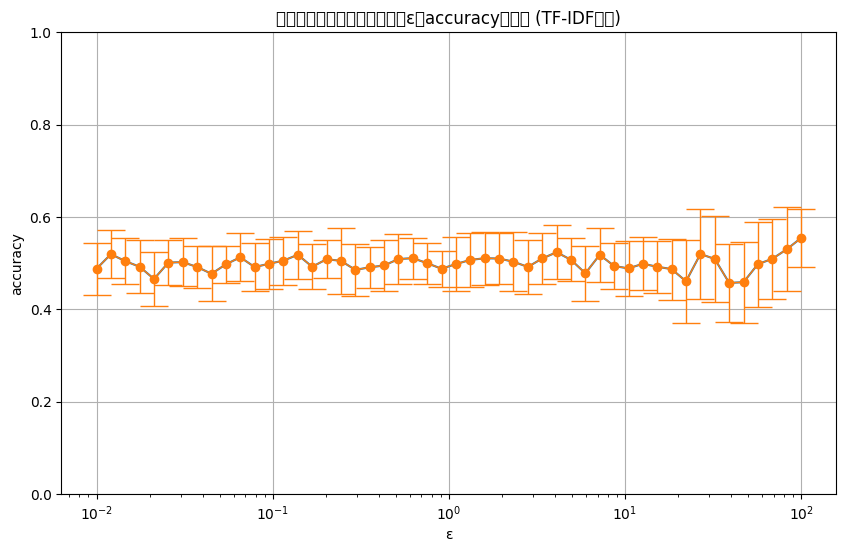

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.models import LogisticRegression as DPLR

epsilons = np.logspace(-2, 2, 50)
dim = np.array(X_train).shape[1]
data_norm = math.sqrt(dim)
accuracies = {}

for epsilon in epsilons:
    accuracy = []
    for i in range(20):
        clf = DPLR(data_norm=data_norm, epsilon=epsilon).fit(X_train, y_train.to_numpy())
        accuracy.append(clf.score(X_test, y_test.to_numpy()))
    accuracies[epsilon] = accuracy

# 結果をグラフに描画
x = epsilons
y = [np.mean(accuracies[eps]) for eps in epsilons]
e = [np.std(accuracies[eps]) for eps in epsilons]

plt.figure(figsize=(10, 6))
plt.semilogx(x, y)
plt.errorbar(x, y, yerr=e, marker='o', capthick=1, capsize=10, lw=1)
plt.xlabel('ε')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('ロジスティック回帰におけるεとaccuracyの関係 (TF-IDF使用)')
plt.grid(True)
plt.show()
